# Mesterséges Intelligencia - Gyakorlat

### 2D Obejktumdetektálás YOLO-val


# 1. YOLOv3

![01_yolov1](./doc/01_yolov1.png)



![04_yolov3](./doc/04_yolov3.png)

### Anchor boxes:

![05_yolov3](./doc/05_yolov3.png)


In [35]:
from __future__ import division

import argparse
import datetime
import os
import time

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable

from models import *
from utils.datasets import *
from utils.transforms import *
from utils.utils import *

# 2. Dataset and labels

## KITTI

Training dataset: 7481 labelled images 

http://www.cvlibs.net/datasets/kitti/
![06_kitti.png](./doc/06_kitti.png)

![08_kitti.jpg](./doc/08_kitti.jpg)


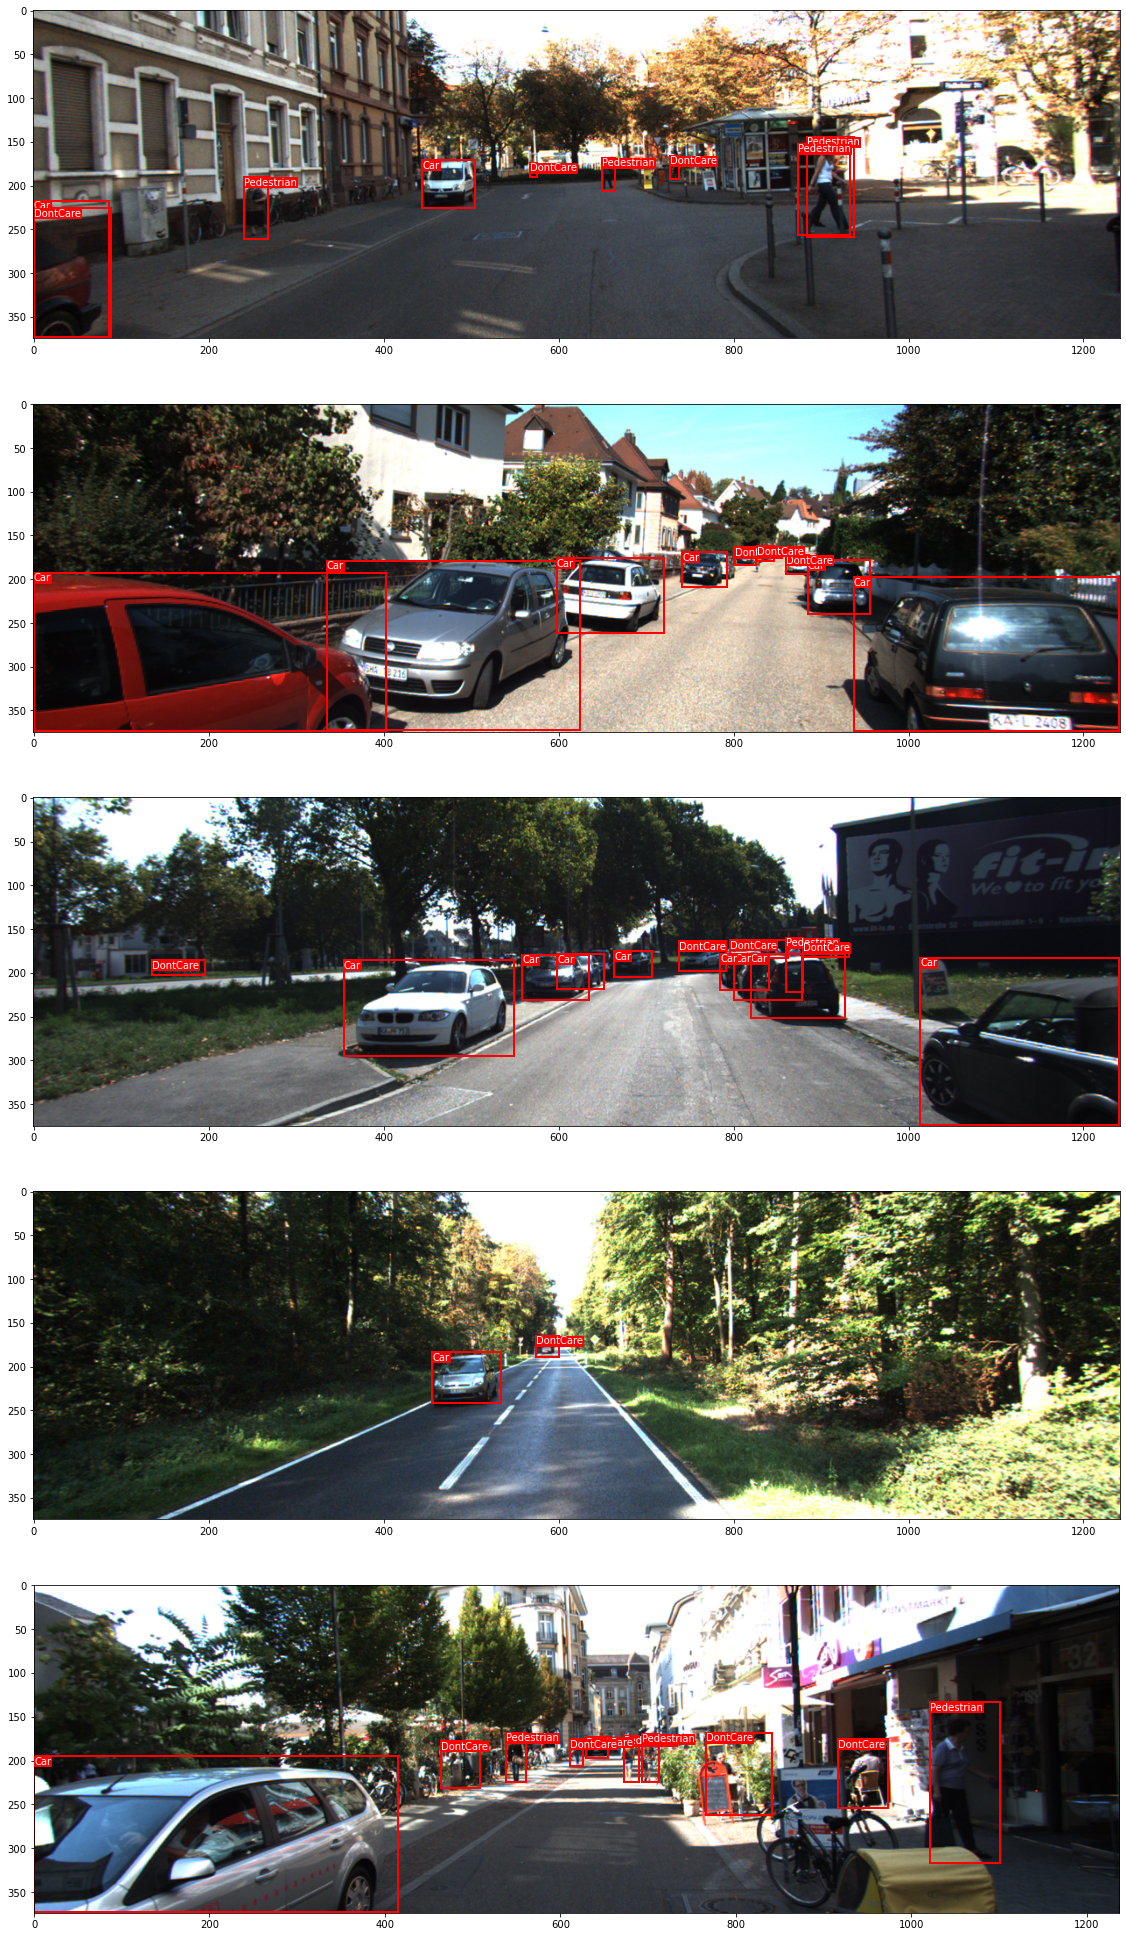

In [34]:
%matplotlib inline

# Define kitti data directories
data_dir = "doc/kitti/"
img_dir = os.path.join(data_dir, "images")
label_dir = os.path.join(data_dir, "labels")

# Initialize plot
fig, axs = plt.subplots(len(os.listdir(img_dir)), figsize=(20, 35))

# Plot images and labels
for idx, img_name in enumerate(os.listdir(img_dir)):
    # Read image from disk
    im = Image.open(os.path.join(img_dir, img_name))
    axs[idx].imshow(im)

    # Read labels from disk and plot 2D bounding box with class name
    with open(os.path.join(label_dir, img_name.split(".")[0] + ".txt")) as label_file:
        labels = label_file.readlines()
        for label in labels:
            label_data = label.split(" ")

            # Extract class (cls) and box top left corner (x1, y1) and box dimensions (box_w, box_h)
            cls = label_data[0]
            x1, y1 = float(label_data[4]), float(label_data[5])
            box_w, box_h = (
                float(label_data[6]) - float(label_data[4]),
                float(label_data[7]) - float(label_data[5]),
            )

            bbox = patches.Rectangle(
                (x1, y1), box_w, box_h, linewidth=2, edgecolor="r", facecolor="none"
            )
            axs[idx].add_patch(bbox)
            axs[idx].text(
                x1,
                y1,
                s=cls,
                color="white",
                verticalalignment="top",
                bbox={"color": "r", "pad": 0},
            )

In [ ]:
for label in labels:
    print(
        label
    )  # type, truncated, occluded, alpha, 2D bbox (x1, y1, x2, y2), dim (h, w, l), 3D loc (x, y, z), rotation_y, score

Labels for YOLOv3:
* Box center (x,y) + Box width/height instead of box edges (x1, y1, x2, y2)
* x, y, w, h are relative to image size
![07_labels.png](./doc/07_labels.png)

# 3. YOLO

In [ ]:
# Options
img_path = "./data/kitti/images/test/002114.png"  # feel free to try a different image in this folder!
model_def = "./config/yolov3-kitti-tiny.cfg"
weights_path = "./weights/yolov3-kitti-tiny.pth"
class_path = "./data/kitti/classes.names"
conf_thres = 0.8
nms_thres = 0.4
iou_thres = 0.5
n_cpu = 0
img_size = 352

In [ ]:
# Define device
device = torch.device("cpu")

In [ ]:
%matplotlib inline

# Load image
img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)
plt.figure(figsize=(15, 15))
plt.imshow(img)

In [ ]:
# Label Placeholder
boxes = np.zeros((1, 5))

img, _ = transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)])((img, boxes))

In [ ]:
# Set up model
model = Darknet(model_def, img_size=img_size).to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(weights_path, map_location=torch.device("cpu")))

# Set model in evaluation mode
model.eval()

In [ ]:
# Load class names
classes = load_classes(class_path)
print(classes)

In [ ]:
# Configure input
img = Variable(img.type(torch.FloatTensor))
img.unsqueeze_(0)

In [ ]:
# Get detections
with torch.no_grad():
    detections = model(img)
    print(detections.shape)

In [ ]:
detections = non_max_suppression(detections, conf_thres, nms_thres)
print(detections[0].shape)
print(detections[0])  # x1, y1, x2, y2, conf, class1, class2

In [ ]:
%matplotlib inline

# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Plot detections
# Create plot
img = np.array(Image.open(img_path))
fig, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(img)

# Draw bounding boxes and labels of detections
if detections is not None:
    # Rescale boxes to original image
    detections_rescaled = rescale_boxes(detections[0], img_size, img.shape[:2])
    unique_labels = detections_rescaled[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_rescaled:

        print("Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle(
            (x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none"
        )
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=classes[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )

## Detekciós és ábrázolási ciklus

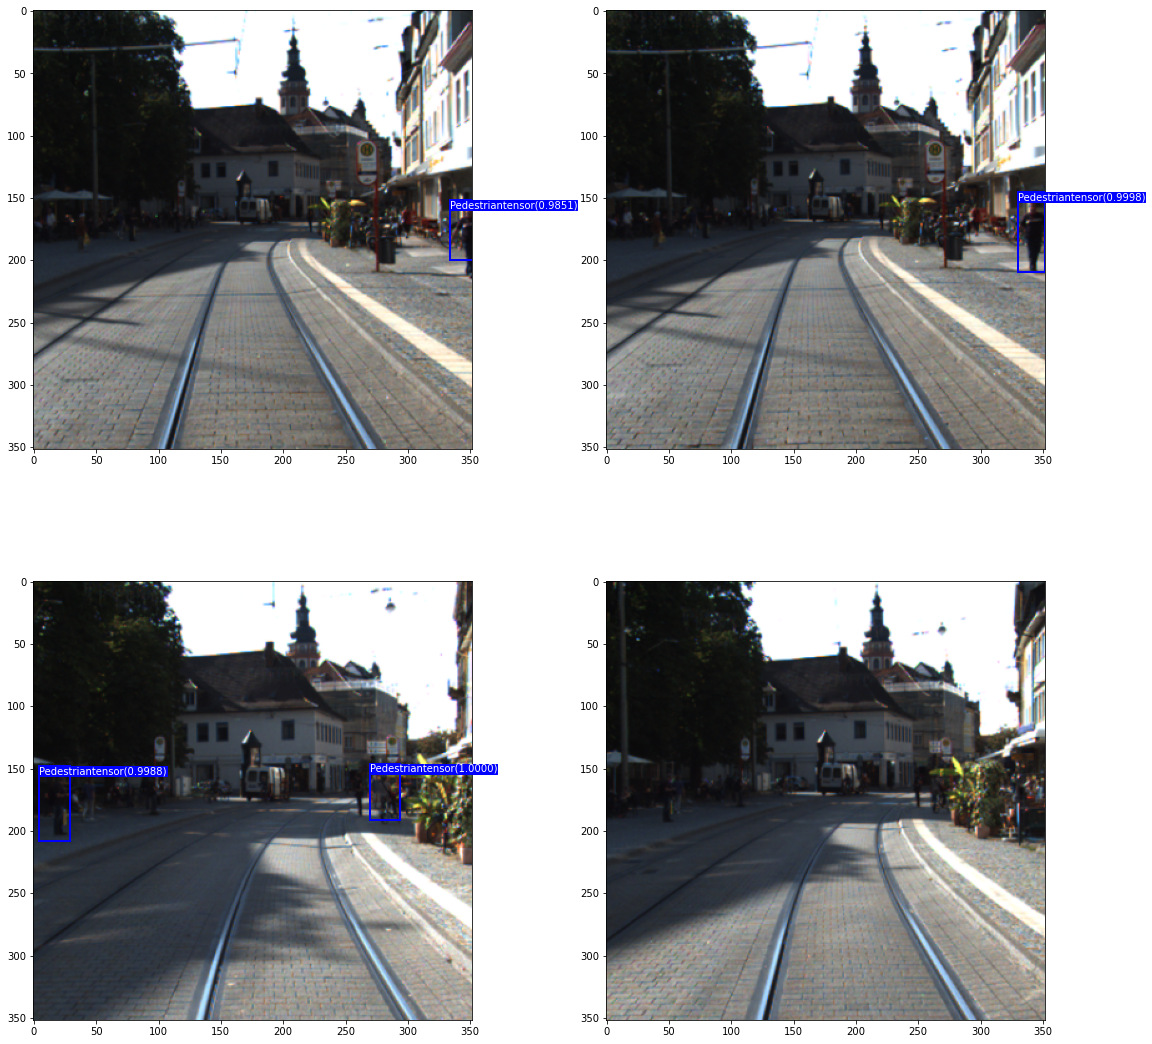

In [36]:
%matplotlib inline

# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111)
# plt.ion()
# # fig.show()
# fig.canvas.draw()
colors = ["r", "b"]

img_dir = "data/kitti/seq01"
img_size = 416  # Assuming an image size (modify as needed)

# Set up the grid for the first 4 images
rows = 2  # 2 rows
cols = 2  # 2 columns
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, img_name in enumerate(os.listdir(img_dir)):
    if idx >= 4:  # Only process the first 4 images
        break

    img_path = os.path.join(img_dir, img_name)
    img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)
    img_shape = img.shape[:2]

    ax = axes[idx]
    ax.imshow(img)

    # Label Placeholder
    boxes = np.zeros((1, 5))

    img, _ = transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)])((img, boxes))
    img = Variable(img.type(torch.FloatTensor))
    img.unsqueeze_(0)

    # Get detections
    with torch.no_grad():
        detections = model(img)
        detections = non_max_suppression(detections, conf_thres, nms_thres)

    # Draw bounding boxes and labels of detections
    if detections[0] is not None:
        detections = rescale_boxes(detections[0], img_size, img_shape)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_w = x2 - x1
            box_h = y2 - y1
            color = colors[int(cls_pred)]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            ax.add_patch(bbox)
            ax.text(x1, y1, s=classes[int(cls_pred)] + str(cls_conf), color="white", verticalalignment="top", bbox={"color": color, "pad": 0})

# Adjust layout
plt.tight_layout()
plt.show()

# 4. Metrics

## Precision / Recall
![precision_recall](./doc/precision_recall.png)


## F1
![f1](./doc/f1.png)


## Average Precision (AP)

![ap](./doc/mean-average-precision-recall.png)


## IoU
![iou](./doc/iou-2.png)


# Kiértékelés

In [ ]:
img_dir = "data/kitti/images/test"
label_dir = "data/kitti/labels/test"

labels = []
metrics = []

for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(label_dir, img_name[:-4] + ".txt")

    # Load image
    img = np.array(Image.open(img_path).convert("RGB"), dtype=np.uint8)

    # Load boxes
    boxes = np.loadtxt(label_path).reshape(-1, 5)

    img, boxes = transforms.Compose([DEFAULT_TRANSFORMS, Resize(img_size)])((img, boxes))

    # Extract labels
    labels += boxes[:, 1].tolist()
    # Rescale boxes
    boxes[:, 2:] = trans_xywh2xyxy(boxes[:, 2:])
    boxes[:, 2:] *= img_size

    # Configure input
    img = Variable(img.type(torch.FloatTensor))
    img.unsqueeze_(0)

    # Get detections
    with torch.no_grad():
        detections = model(img)
        detections = non_max_suppression(detections, conf_thres, nms_thres)

    # Gather batch statistics
    metrics += get_batch_statistics(
        detections, boxes, iou_threshold=iou_thres
    )

# Concatenate sample statistics
true_positives, pred_scores, pred_labels = [
    np.concatenate(x, 0) for x in list(zip(*metrics))
]
precision, recall, AP, f1, ap_class = ap_per_class(
    true_positives, pred_scores, pred_labels, labels
)

# Print evaluation results
print("Evaluation Results:\n")
print("Class-wise Metrics:")
for i, c in enumerate(ap_class):
    print(f"Class '{classes[c]}' (ID: {c}):")
    print(f"    Average Precision: {AP[i]:.4f}")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall: {recall[i]:.4f}")
    print(f"    F1 Score: {f1[i]:.4f}\n")

print(f"Mean Average Precision (mAP): {AP.mean():.4f}")